In [0]:
#必要なパッケージのインポート
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib import animation, rc
from IPython.display import HTML

In [0]:
# animate over some set of x, y
x = np.linspace(-4, 4, 100)
rv = scipy.stats.norm(loc=0, scale=1)
y = rv.pdf(x)

# 以下，正規ー正規モデルでのMCMCの例

In [0]:
# データの生成
n = 1000 #サンプルサイズ
sigma = 0.1
lam = 1/sigma**2
data = sigma * np.random.randn(n) #真の分布を平均0標準偏差0.1の正規分布とする

In [0]:
# 制御変数
K = 1000 #サンプリング数
thin = 20 #サンプリング周期
burnin = 20000 #初期値の影響を切り捨てるバーンイン
iters = burnin + thin*K #実際の繰り返し回数
ep = 0.001 #提案分布の分散
# ハイパーパラメータ
m = 0
s = 10
l = 1/s**2


## モデリング

* モデル
$$p(x|w) = \mathrm{N}(x|w,\sigma=0.1)\propto \exp \left( -\frac{1}{2\sigma^2}(x-w)^2\right)$$

* 事前分布
$$\varphi(w) = \mathrm{N}(w|m=0,l=0.01)\propto \exp \left( -\frac{l}{2}w^2\right)$$

このとき，事後分布は

$$\psi(w|X^n) \propto \prod_{i=1}^n p(X_i|w)\varphi(w) \propto \exp \left(-\frac{1}{2\sigma^2}\sum_{i=1}^n (X_i-w)^2 -\frac{l}{2}w^2 \right)$$

であり，指数部分に注目すると，
$$-\frac{1}{2\sigma^2}\sum_{i=1}^n (X_i-w)^2 -\frac{l}{2}w^2 = -\frac{1}{2} \left( \lambda \sum_{i=1}^n (X_i)^2 -2\lambda w \sum_{i=1}^n X_i + (n\lambda + l) w^2\right)$$
である．ただし$\lambda = 1/\sigma^2$と置いた．


In [13]:
#MCMCの準備
sqsumdata = sum(data**2)
sumdata = sum(data)
def hamiltonian(w):
  first = lam * sqsumdata
  second = 2*lam*sumdata * w
  third = (n*lam+l) * w**2
  return (first - second + third)/2

def acceptance_ratio(source,target):
  delta = hamiltonian(target) - hamiltonian(source)
  prob = min(1, np.exp(-delta))
  return prob

#パラメータの初期値
w = 0 #s*np.random.randn()
print(w)
all_ws = np.zeros(iters)
ws = np.zeros(K)

0


In [0]:
#MCMC
##サンプリング
for iter in range(iters):
  delta_w = ep*np.random.randn()
  source = w
  target = w + delta_w
  r = acceptance_ratio(source,target)
  R = np.random.rand()
  w += (r>=R) * delta_w
  all_ws[iter] = w
##バーンインとシニング
for i in range(K):
  ws[i] = all_ws[burnin + thin*i]

#事後分布を書けと言われたらall_wsではなくwsのヒストグラムになることに注意！


一方で，共役事前分布を使っていたので事後分布は解析的に計算できて

$$\psi(w|X^n) = \mathrm{N}(w|\hat{m},\hat{l}),$$
$$\hat{m} = \frac{\lambda \sum_{i=1}^n X_i + lm}{\hat{l}},$$
$$\hat{l} = n\lambda+l.$$

hat_m, hat_l = [-0.0032347148094832427, 100000.00999999998]


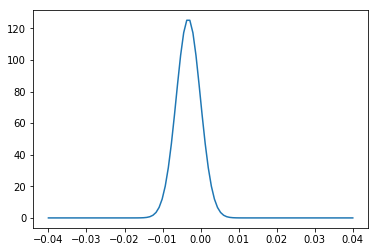

In [15]:
#事後分布の理論密度関数
hat_l = n*lam + l
hat_m = (lam * sumdata + l*m)/ hat_l
print("hat_m, hat_l =",[hat_m, hat_l])
x = np.linspace(-0.04, 0.04, 100)
rv = scipy.stats.norm(loc=hat_m, scale=1/np.sqrt(hat_l))
y = rv.pdf(x)
plt.plot(x,y)
#y = np.sin(x)

In [16]:
#定常分布の収束アニメーション作成
#青い理論密度関数に赤い密度ヒストグラムが収束していく
#アニメーション表示と操作：
## https://medium.com/lambda-school-machine-learning/making-animations-work-in-google-colaboratory-new-home-for-ml-prototyping-c6147186ae75

fig, ax = plt.subplots()
plt.close()
arr = []
line1, = ax.plot([], [], lw=2)
line2=ax.hist(arr,density=True, histtype='stepfilled', alpha=0.5, color="red")

# initialization function: plot the background of each frame
def init():
    ax.set_xlim(( -0.04, 0.04))
    ax.set_ylim((0, 150))
    line1.set_data(x, y)
    return (line1,)
# animation function: this is called sequentially
def animate(i):
  arr.append(ws[5*i])
  arr.append(ws[5*i+1])
  arr.append(ws[5*i+2])
  arr.append(ws[5*i+3])
  arr.append(ws[5*i+4])
  ax.cla()
  ax.set_xlim(( -0.04, 0.04))
  ax.set_ylim((0, 150))
  ax.plot(x,y,lw=2)
  line2=ax.hist(arr,bins=8, density=True, histtype='stepfilled', alpha=0.5, color="red")
  return (line2,)
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=100)#, blit=True)
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.